In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Importamos pandas para el manejo de datos en forma de dataframes
import pandas as pd

# Plotting library
from matplotlib import pyplot
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
# from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
# import utils
# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [2]:
#  datos de entrenamiento almacenados en los arreglos X, y
# Lectura del dataset con las columnas necesarias y tomando un total de 80000 registros
data = pd.read_csv('/home/dilpz/Documentos/SIS420-2024/datasets/sign_mnist_train.csv')
data_test = pd.read_csv('/home/dilpz/Documentos/SIS420-2024/datasets/sign_mnist_test.csv')

# Seleccionamos las columnas para X y la columna 'shares' para y
X_test = data_test.drop(['label'], axis=1).values
y_test = data_test['label'].values
m_test = len(y_test)

# Seleccionamos las columnas para X y la columna 'shares' para y
X_train = data.drop(['label'], axis=1).values
y_train = data['label'].values
m_train = len(y_train)

# Conteo de los valores para identificar las clases resultantes
class_counts = data["label"].value_counts()

# Imprimir los valores de las clases resultantes
print(f'La cantidad de clases presentes son: ')
print(class_counts)

# Revision de los valores nan para verificar si existen y llenar con la media si es posible
print("\nCantidad de NaN por columna")
print(data.isna().sum())





La cantidad de clases presentes son: 
17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
14    1196
3     1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

Cantidad de NaN por columna
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


In [3]:
X_train

array([[107, 118, 127, ..., 204, 203, 202],
       [155, 157, 156, ..., 103, 135, 149],
       [187, 188, 188, ..., 195, 194, 195],
       ...,
       [174, 174, 174, ..., 202, 200, 200],
       [177, 181, 184, ...,  64,  87,  93],
       [179, 180, 180, ..., 205, 209, 215]])

In [4]:
# Configurando parametros necesarios
input_layer_size  = X_train.shape[1] 
hidden_layer_size = 10
num_labels = 25 


pesos = {}
pesos['Theta1'] = np.random.rand( hidden_layer_size, input_layer_size + 1)
pesos['Theta2'] = np.random.rand(num_labels, hidden_layer_size+1)

Theta1, Theta2 = pesos['Theta1'], pesos['Theta2']

print(Theta1.ravel().shape)
print(Theta2.ravel().shape)

nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])
print(nn_params.shape)

(7850,)
(275,)
(8125,)


In [5]:
def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))


def sigmoidGradient(z):
  
    g = np.zeros(z.shape)

    g = sigmoid(z) * (1 - sigmoid(z))

    return g

In [6]:
def  featureNormalize(X):
    X_norm = X.copy()

    #creamos un array de ceros con una longitud igual al número de columnas en el array X. La variable mu y sigma se inicializa como este array de ceros.
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    #Creamos el promedio de cada columna de X
    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)

    sigma[sigma == 0] = 1

    #normalizamos los datos con la siguiente formula
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [7]:
X_norm, mu, sigma = featureNormalize(X_train)
X_norm.shape

(27455, 784)

In [8]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    m = y.size
         
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    a2 = sigmoid(a1.dot(Theta1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)
    
    a3 = sigmoid(a2.dot(Theta2.T))
    
    # print("-"*20)
    # print(y.shape)
    # print(y.reshape(-1))
    # print("-"*20)
    y_matrix = y.reshape(-1)
    # print(y.shape)
    y_matrix = np.eye(num_labels)[y_matrix]
    # print(y_matrix)

    temp1 = Theta1
    temp2 = Theta2
    
    # Agregar el termino de regularización
    
    reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(temp1[:, 1:])) + np.sum(np.square(temp2[:, 1:])))
    
    J = (-1 / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix)) + reg_term
    
    # Backpropogation
    
    delta_3 = a3 - y_matrix
    delta_2 = delta_3.dot(Theta2)[:, 1:] * sigmoidGradient(a1.dot(Theta1.T))

    Delta1 = delta_2.T.dot(a1)
    Delta2 = delta_3.T.dot(a2)
    
    # Agregar regularización al gradiente

    Theta1_grad = (1 / m) * Delta1
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (lambda_ / m) * Theta1[:, 1:]
    
    Theta2_grad = (1 / m) * Delta2
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (lambda_ / m) * Theta2[:, 1:]
    
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    
    return J, grad

In [9]:
print("Longitud de nn_params:", len(nn_params))
print("Expected size for Theta2:", (hidden_layer_size + 1) * num_labels)

Longitud de nn_params: 8125
Expected size for Theta2: 275


In [10]:
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X_norm, y_train, lambda_)
print('Costo en parametros (cargado de ex4weights): %.6f ' % J)

Costo en parametros (cargado de ex4weights): 82.886522 


<ipython-input-5-06d1f75bcbb5>:5: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


In [11]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    
    W = np.zeros((L_out, 1 + L_in))
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

    return W

In [12]:
print('Inicialización de parámetros de redes neuronales...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Desenrrollr parametros
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Inicialización de parámetros de redes neuronales...


In [13]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 1000}

#  You should also try different values of lambda
lambda_ = 100

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X_norm, y_train, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

In [14]:
def predict(Theta1, Theta2, X):
    # Useful values
    m = X.shape[0]
    
    # You need to return the following variables correctly
    # 
    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    return p

In [15]:
pred = predict(Theta1, Theta2, X_norm[:])
print(pred)
print('Training Set Accuracy: %f' % (np.mean(pred == y_train[:]) * 100))

[23  6  2 ... 18 17 23]
Training Set Accuracy: 93.061373


In [16]:
#Normalizamos todos
X_test_norm= (X_test - mu) / sigma

print(y_test)
pred = predict(Theta1, Theta2, X_test_norm)
print(pred)
print('Training Set Accuracy: %f' % (np.mean(pred == y_test) * 100))


[ 6  5 10 ...  2  4  2]
[ 6  5 17 ... 14  4 14]
Training Set Accuracy: 54.155047


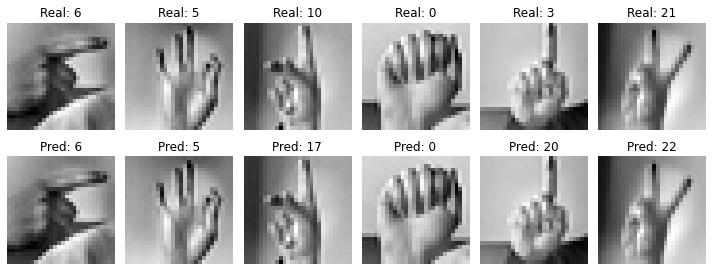

In [17]:
# Seleccionamos las primeras 6 imágenes
images = X_test_norm[:6]
real_labels = y_test[:6]
predicted_labels = pred[:6]

# Creamos una figura con 12 subplots (dos para cada imagen)
fig, axes = plt.subplots(2, 6, figsize=(10, 4))

for i in range(6):
    # Primera fila: imágenes con etiquetas reales
    axes[0, i].imshow(images[i].reshape(28, 28), cmap='gray')  # Mostramos la imagen en escala de grises
    axes[0, i].set_title(f"Real: {real_labels[i]}")  # Mostramos la etiqueta real
    axes[0, i].axis('off')  # Quitamos los ejes

    # Segunda fila: imágenes con etiquetas predichas
    axes[1, i].imshow(images[i].reshape(28, 28), cmap='gray')  # Mostramos la misma imagen en escala de grises
    axes[1, i].set_title(f"Pred: {predicted_labels[i]}")  # Mostramos la etiqueta predicha
    axes[1, i].axis('off')  # Quitamos los ejes

plt.tight_layout()
plt.show()